# Emittance Calculation

In [1432]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import ipywidgets
from scipy.fft import fft, fftfreq
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression

## Import csv with the positions intensities and other useful data to calculate the emittance

In [1433]:
df = pd.read_csv("Results/Results_final.csv")

In [1434]:
df

,,Label,Area,Mean,Min,Max,X,Y,XM,YM,Perim.,Major,Minor,Angle,IntDen,RawIntDen
0,1,pperpot_6K-2.tif:0001-0015,0.060573,17788.000000,10240,28202,8.112939,12.118141,8.113629,12.117228,0.960936,0.312522,0.246779,141.858252,1077.471794,6421468
1,2,pperpot_6K-2.tif:0002-0015,0.132052,26488.404066,12850,42710,8.166679,0.173604,8.166634,0.172610,1.380431,0.460020,0.365494,176.031102,3497.857499,20846374
2,3,pperpot_6K-2.tif:0003-0017,0.124837,24723.997312,11225,39577,8.713135,0.193414,8.710933,0.192225,1.383574,0.417102,0.381077,121.360795,3086.478178,18394654
3,4,pperpot_6K-2.tif:0004-0053,0.115777,25306.771014,14571,37449,8.703223,0.700501,8.702714,0.700380,1.283090,0.420540,0.350529,84.332441,2929.931141,17461672
4,5,pperpot_6K-2.tif:0005-0053,0.146147,25540.195178,10286,45056,9.263129,0.689545,9.262096,0.692269,1.430943,0.440285,0.422635,117.289914,3732.621509,22245510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386,pperpot_6K-2.tif:0386-0930,0.129703,29061.078913,12297,51192,4.872051,12.078766,4.874666,12.079468,1.365255,0.429151,0.384814,32.847987,3769.318319,22464214
386,387,pperpot_6K-2.tif:0387-0931,0.117119,27933.532951,15788,43451,5.966702,12.069618,5.966854,12.071516,1.276804,0.395361,0.377175,74.390376,3271.544843,19497606
387,388,pperpot_6K-2.tif:0388-0931,0.122656,27213.321477,11204,43008,6.495168,12.072191,6.495377,12.071525,1.281249,0.408008,0.382764,54.063681,3337.878442,19892938
388,389,pperpot_6K-2.tif:0389-0931,0.110575,24821.180577,13168,37659,7.046633,12.079790,7.046243,12.080622,1.255342,0.391491,0.359621,98.993634,2744.602384,16357158


## Find the center point of the beam: Get the spot with the least deviation from the sorrounding ones
Taking into account that the *beam is diverging* we will suppose the the least deviation from the others means that is the center. 
For each point we save the sumation of the 4 minimum distances from all the other points. We will consider that the center will be the spot whose sumation is the minimum. It must fulfill also that is inside a (Ax, Ay) bounds from the pyhiscal center.

In [1435]:
# Define the (Ax, Ay) bounds (mm)
Ax = 1
Ay = 1

In [1436]:
# Get the X and Y arrays
x = df['X'].to_numpy()
y = df['Y'].to_numpy()

In [1437]:
# Calculate the center
cx = (np.max(x) + np.min(x))/2
cy = (np.max(y) + np.min(y))/2

In [1438]:
# Get the 4 minimum distances and then the addition of them for each point
# 5 distances buffer. One is going to be 0, because it is the distance from 
# itself.
buffer4d = np.zeros((5))
buffer4dindex = []
mindists = np.zeros((x.shape))
mindistsindex = []
for i in range(len(x)):
    for j in range(len(x)):
       distcalc = np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       if j < 5:
           buffer4d[j] = distcalc
           buffer4dindex.append((distcalc,j))
       else:
           buffer4d = np.sort(buffer4d)
           buffer4dindex = sorted(buffer4dindex, key=lambda x: x[0]) 
           if distcalc < buffer4d[4]:
               buffer4d[4] = distcalc
               buffer4dindex[4]= (distcalc,j)
               buffer4d = np.sort(buffer4d) # The last index must be sorted too
       
    mindists[i] = np.sum(buffer4d)
    mindistsindex.append(buffer4dindex)
    buffer4dindex = []
    i = i + 1
# Get the index of the the sumation of the 4 minimum distances from all the 
# other points.
centerindex = np.argmin(mindists) 
print("Center index: ", centerindex)
print("Center index indices: ", mindistsindex[centerindex])



Center index:  348
Center index indices:  [(0.0, 348), (0.4786656583169509, 347), (0.5226478679158645, 340), (0.5279095503597182, 351), (0.5424136167354218, 359)]


In [1439]:
# Remove the minima that is not inside the (Ax, Ay) boundaries
while np.abs(x[centerindex]-cx)> Ax and np.abs(y[centerindex]-cy)> Ay:
    mindists = np.delete(mindists,centerindex)
    centerindex = list(mindists).index(min(mindists))
    
print("Center index: ", centerindex)
print("Center distance from pyhisical center: ", 
      x[centerindex]-cx, y[centerindex]-cy)
print("Center index neighbour indices: ", mindistsindex[centerindex])

Center index:  197
Center distance from pyhisical center:  -0.7472050000000001 0.008994500000000905
Center index neighbour indices:  [(0.0, 197), (0.5290561329017931, 198), (0.5381419025517339, 196), (0.5409161758738593, 212), (0.5636015288357553, 159)]


In [1440]:
# Translate all points to the calculated center 
x = x - x[centerindex]
y = y - y[centerindex]

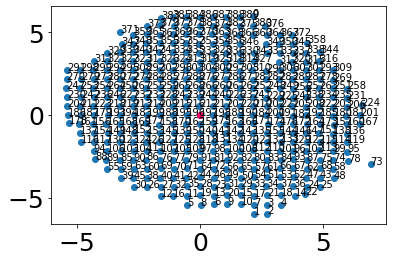

In [1441]:
# Draw the points and highlight the center.
fig, ax = plt.subplots()
ax.scatter(x, y)

for i in range(len(x)):
    if i == centerindex:
        ax.scatter(x[i], y[i], color="#FF0066")
    ax.annotate(i, (x[i], y[i]))
    
plt.rcParams['figure.figsize'] = [9.5, 6.0]
#plt.figure(figsize=(32, 24), dpi=300)

In [1442]:
#Generates a radial mesh with variable distance between consecutive rings
def RadialMeshGenerator(pointDis,MeshSize,ratio):
     # number of bins in r and theta dimensions
    N_bins_theta = round(MeshSize/(np.sqrt(2**3)*pointDis))*4
    N_bins_r = round(MeshSize/(np.sqrt(2**3)*pointDis))

    # limits in r dimension
    rmin = 0
    rmax = MeshSize/2

    # setting up 1D arrays in r and theta
    pausur=(rmax)/N_bins_r
    up=pointDis/np.sqrt(2)*ratio
    r=np.zeros(N_bins_r)
    for i in range(N_bins_r):
        r[i]=pausur*i+up*i**2
     
    theta = np.linspace(0, 2*np.pi, N_bins_theta)  # N.B. radians not degrees

    # 'gridding' the 1D arrays into 2D arrays so they can be used by pcolor
    theta, r = np.meshgrid(theta, r)
    return theta,r

#Generates a square mesh with the physical dimensions of the device
def MeshGenerator(pointDis,MeshSize):
    pausux=pointDis
    pausuy=pointDis
    numx=round(MeshSize/pointDis)
    numy=round(MeshSize/pointDis)
    if(np.mod(numx,2)==0):
        numx+=1
    if(np.mod(numy,2)==0):
        numy+=1
    x=np.zeros(numx*numy)
    y=np.zeros(numy*numy)
    for i in range(numx):
        for j in range(numy):
            x[j+numx*i]=pausux*i-MeshSize/2
            y[j+numy*i]=pausuy*j-MeshSize/2
    return x,y


## Create a master (regular) mesh taking the  calculated center. We suppose grid is symmetric in both x and y axes. 
We also scale the image so the distance between the points near the calculated center (Amesh) is the same that the distance between the points of the Pepperpot grid (Aactualmesh).

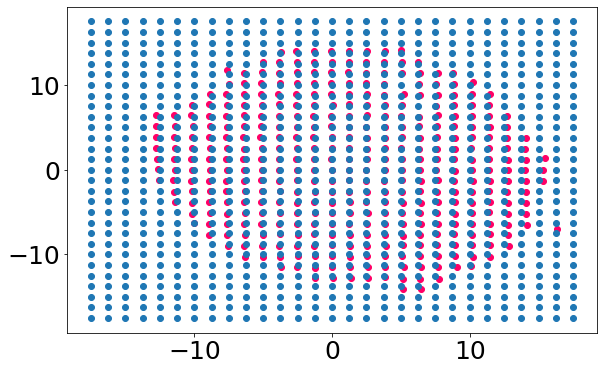

In [1443]:

# Define the distance from spots of the master mesh.
Aactualmesh = 1.25 # in mm.
# Scale our points set
Amesh = np.abs(x[centerindex]-x[centerindex+1])
xs = x * Aactualmesh/Amesh
ys = y * Aactualmesh/Amesh

Amesh = Aactualmesh # Now both are the same

# Define the numer of extra points we will draw in case the beam is not
# circular. It has to be even.
extraMesh = 4

# Calculate the number of points we need to create the mesh
# We need to be odd, so, if it is even we sum one.
# It is easier to add one than to calculate which is the longest set.
nx = np.ceil(np.abs(np.max(xs) - np.min(xs))/Amesh)
if np.mod(nx,2) == 0:
    nx = nx + 1
ny = np.ceil(np.abs(np.max(ys) - np.min(ys))/Amesh)
if np.mod(ny,2) == 0:
    ny = ny + 1
# Add extra points
nx = nx + extraMesh
ny = ny + extraMesh
#Square mesh with measurements
fig, ax = plt.subplots()
ax.scatter(xs,ys,color="#FF0066")
xm,ym=MeshGenerator(Aactualmesh,35)
ax.scatter(xm,ym)

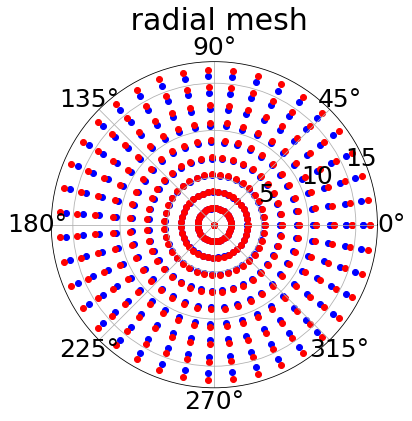

In [1444]:
#radial equidistant mesh with diverging mesh
theta0,r0=RadialMeshGenerator(Aactualmesh,35,0)
theta05,r05=RadialMeshGenerator(Aactualmesh,35,0.01)
ax1=plt.subplot(111,projection="polar")
ax1.set_title(" radial mesh")
ax1.scatter(theta0,r0,color="blue")
ax2=plt.subplot(111,projection="polar")
ax2.scatter(theta05,r05,color="red")
#Extract one meridian from equidistant and diverging meshes
rex0=np.zeros(len(r0))
rex05=np.zeros(len(r05))
for i in range(len(r0)):
    rex0[i]=r0[i][0]
for i in range(len(r05)):
    rex05[i]=r05[i][0]

## Emittance Calculation
$\epsilon_{rms}=\sqrt{<x^{2}><x'^{2}>-<xx'>^{2}}$ 

with

$<x^{2}>=\frac{1}{N}\sum \limits _{i=1} ^{N} (x_{i}-\overline {x})^{2}$ 

$\overline {x} = \frac{1}{N}\sum \limits _{i=1} ^{N} x_{i}$ 

$<xx'>=\frac{1}{N}\sum \limits _{i=1} ^{N} (x_{i}-\overline {x})(x'_{i}-\overline {x'})$ 

Emittance x rms (mmmrad):  0.009954267618369516
Emittance y rms (mmmrad):  0.012286504099979414
Emittance x rms (pimmmrad):  0.003168541792646194
Emittance y rms (pimmmrad):  0.003910915721661125


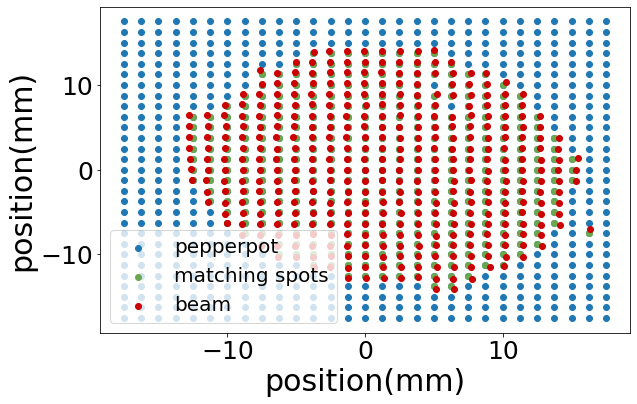

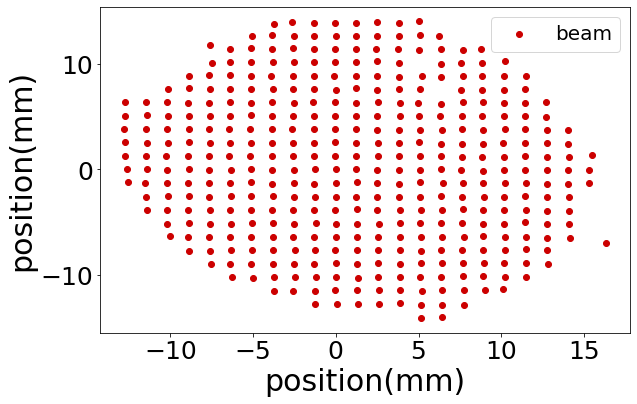

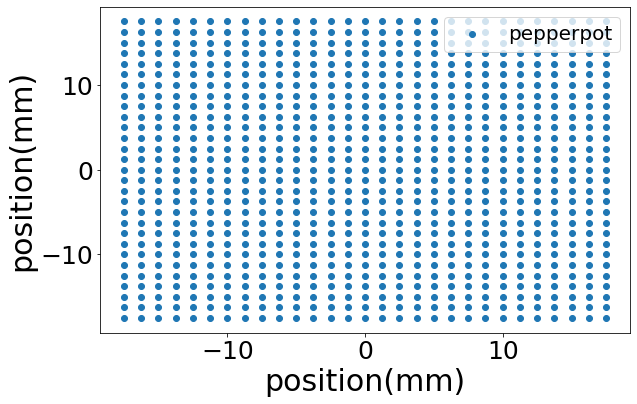

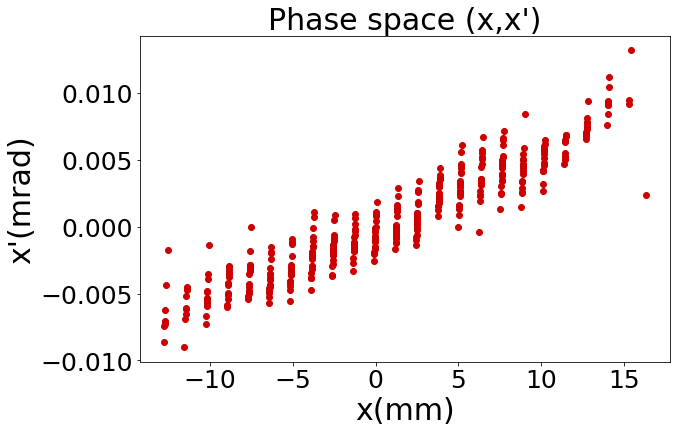

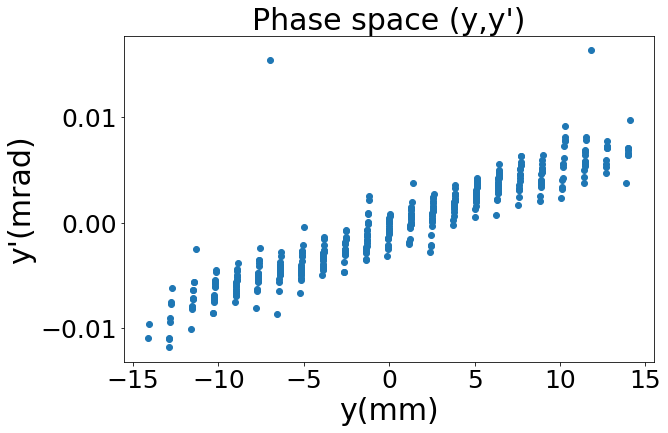

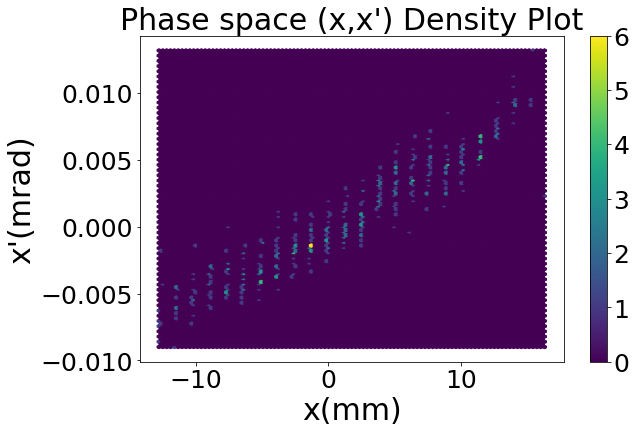

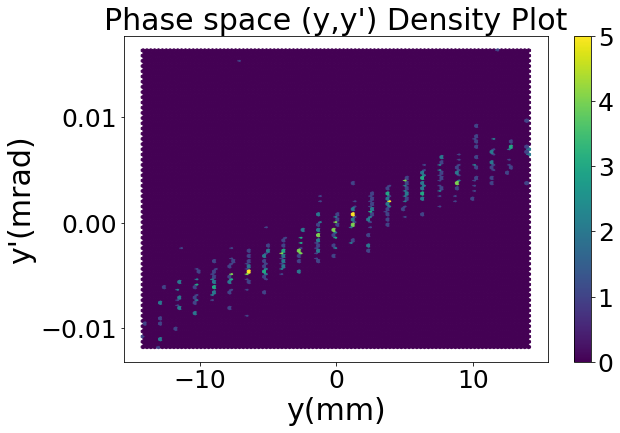

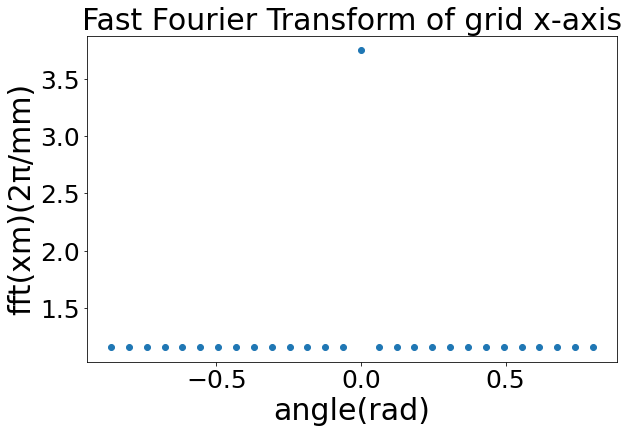

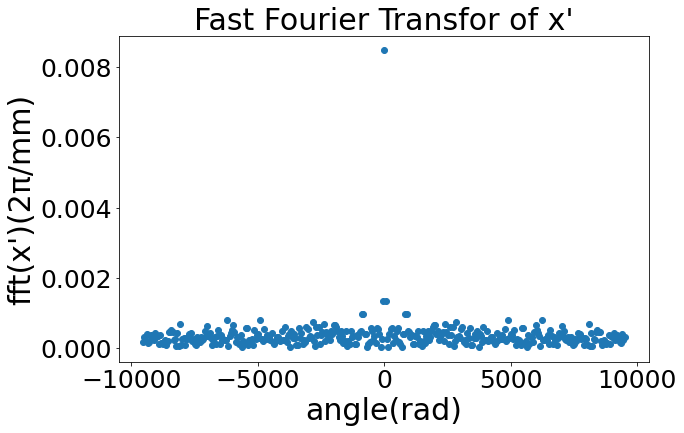

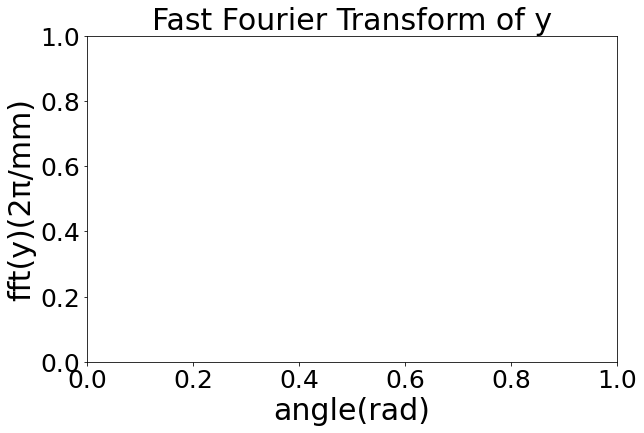

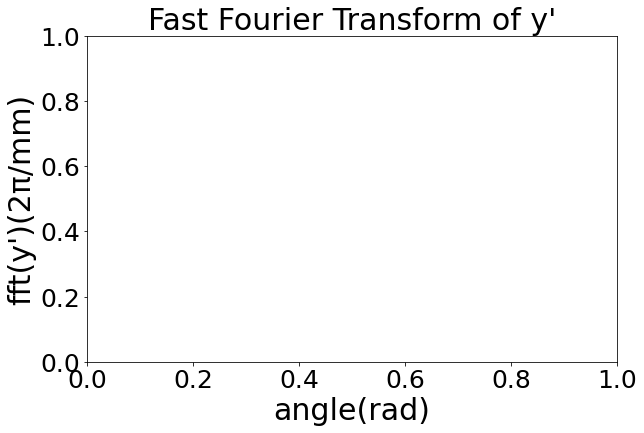

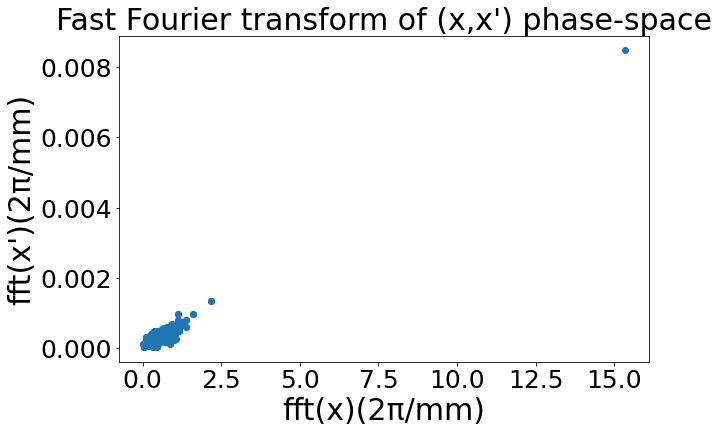

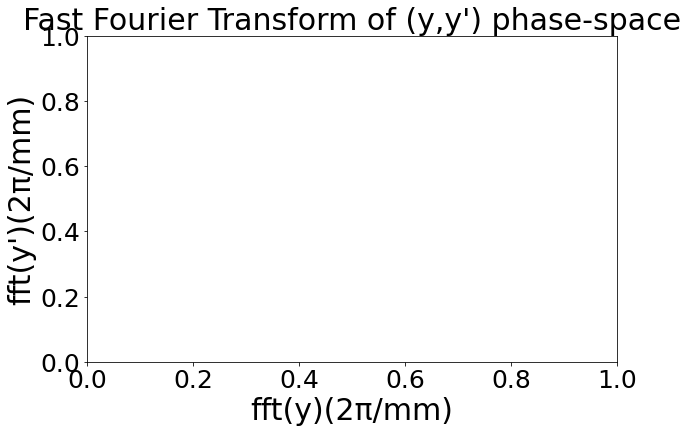

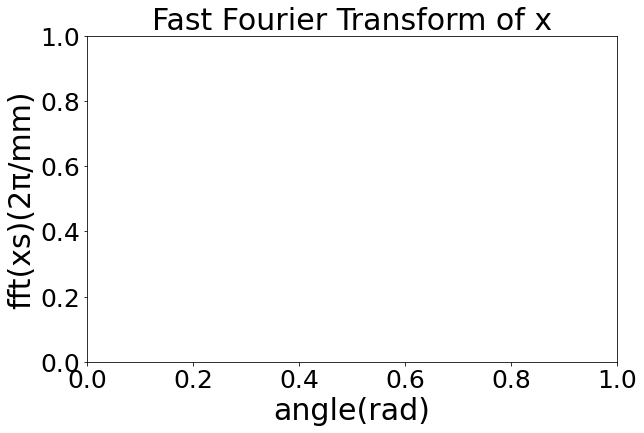

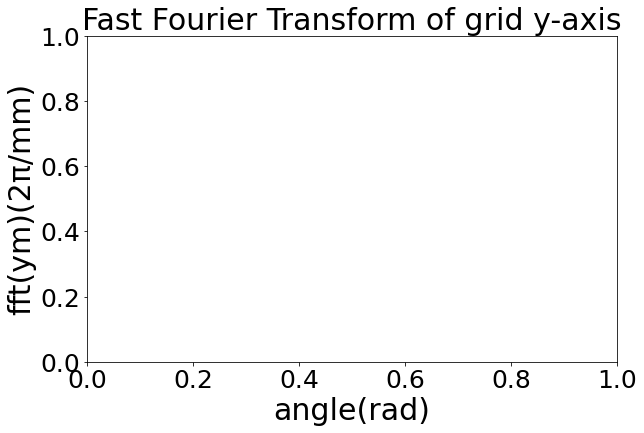

In [1445]:
# Define the distance from the mesh and the image. This value is set by 
# pepper physical imlpementation
L = 35 # mm
# Find the mesh and the image related points indices
meshrelation = np.zeros((len(xs),2))
mindistindex = np.zeros((1,2))
for i in range(len(xs)):
    mindist = Amesh
    distcalc = 0
    for j in range(len(xm)):
        distcalc = np.sqrt((xs[i]-xm[j])**2+(ys[i]-ym[j])**2)
        if mindist > distcalc:
            mindistindex [0][0]= i
            mindistindex [0][1]= j
            mindist = distcalc
    meshrelation[i] = mindistindex
#print(meshrelation)
#Find equidistant and diverging mesh matching points
rmatch=[]
matchin=[]
for i in range(len(rex05)):
    for j in range(len(rex0)):
        if(np.abs(rex0[j]-rex05[i])<Aactualmesh*np.sqrt(2)):
            rmatch.append(rex0[j])
            matchin.append(j)
rmatch=np.array(rmatch)
#Plot radial mesh with matching points highlighted
""""shape=(len(rmatch),len(theta0))
matchplot=np.zeros(shape)
thetaplot=np.zeros(shape)
rtheta=np.linspace(0,2*np.pi,len(rmatch))
for i in range(len(rmatch)):
    for j in range(len(theta0)):
        matchplot[i][j]=rmatch[i]
        thetaplot[i][j]=rtheta[j]
ax4=plt.subplot(111,projection="polar")
ax4.scatter(theta0,r0,label="equidistant")
ax4.scatter(theta05,r05,color="red",label="diverging")
ax4.scatter(thetaplot,matchplot,color="green",label="matching")"""
# Draw the points and highlight the center.
fig, ax = plt.subplots()
plt.rc('font', size=30) #controls default text size
plt.rc('axes', titlesize=30) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
ax.scatter(xm, ym, marker = 'o',label="pepperpot")
for i in range(len(xs)):
    ax.scatter(xm[int(meshrelation[i][1])], ym[int(meshrelation[i][1])], 
               color="#6AA84F")
    #ax.annotate(i, (xs[i], ys[i]))
    #ax.annotate(i, (xm[int(meshrelation[i][1])], ym[int(meshrelation[i][1])]))
ax.scatter(xm[int(meshrelation[i][1])], ym[int(meshrelation[i][1])], 
           color="#6AA84F", label="matching spots") #Repeated last to set legend
ax.scatter(xs,ys,color="#CC0000", label="beam")
ax.legend()
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")
plt.savefig ("positions")

# Save individual figures
fig, ax = plt.subplots()
ax.scatter(xs,ys,color="#CC0000", label="beam")
ax.legend()
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")
plt.savefig ("beam_positions")

# Save individual figures
fig, ax = plt.subplots()
ax.scatter(xm, ym, marker = 'o',label="pepperpot")
ax.legend()
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")
plt.savefig ("mesh_positions")


# Calculate x' and y'
xsp = np.zeros(len(xs))
ysp = np.zeros(len(ys))
i = 0
for inds in meshrelation:
    #print(xs[int(inds[0])])
    xsp[i] = (xs[int(inds[0])] - xm[int(inds[1])])/L
    ysp[i] = (ys[int(inds[0])] - ym[int(inds[1])])/L
    i = i + 1


xsmean = np.mean(xs) # \overline{x}
xspmean = np.mean(xsp) # \overline{x'}
xs2 = np.mean((xs-xsmean)**2) # <x^{2}>
xsp2 = np.mean((xsp-xspmean)**2) # <x'^{2}>
xsxsp = np.mean((xs-xsmean)*(xsp-xspmean)) # <xx'> 
ysmean = np.mean(ys) 
yspmean = np.mean(ysp)
ys2 = np.mean((ys-ysmean)**2) 
ysp2 = np.mean((ysp-yspmean)**2)
ysysp = np.mean((ys-ysmean)*(ysp-yspmean)) 

exrms = np.sqrt(xs2*xsp2-xsxsp**2)
eyrms = np.sqrt(ys2*ysp2-ysysp**2)

print ("Emittance x rms (mmmrad): ", exrms)
print ("Emittance y rms (mmmrad): ", eyrms)

print ("Emittance x rms (pimmmrad): ", exrms/np.pi)
print ("Emittance y rms (pimmmrad): ", eyrms/np.pi)

# Phase spaces
fig, ax = plt.subplots()
ax.scatter(xs,xsp,color="#CC0000")
ax.set_xlabel ("x(mm)")
ax.set_ylabel ("x'(mrad)")
ax.set_title ("Phase space (x,x')")
plt.savefig ("exrms")
fig1, ax1 = plt.subplots()
ax1.scatter(ys,ysp)
ax1.set_xlabel ("y(mm)")
ax1.set_ylabel ("y'(mrad)")
ax1.set_title ("Phase space (y,y')")
plt.savefig ("eyrms")

# Densities
fig, ax = plt.subplots()
sca = ax.hexbin(xs,xsp)
ax.set_xlabel('x(mm)')
ax.set_ylabel("x'(mrad)")
ax.set_title ("Phase space (x,x') Density Plot")
fig.colorbar(sca)
plt.savefig ("exrms_density")

fig, ax = plt.subplots()
sca = ax.hexbin(ys,ysp)
ax.set_xlabel('y(mm)')
ax.set_ylabel("y'(mrad)")
ax.set_title ("Phase space (y,y') Density Plot")
fig.colorbar(sca)
plt.savefig ("eyrms_density")

#Changing positions and divergence vectors to difference vectors between consecutive values
xm=np.linspace(-17.5,17.5,round(2*17.5/Aactualmesh))
ym=np.linspace(-17.5,17.5,round(2*17.5/Aactualmesh))
for i in range(len(xm)-1):
    xm[i]=np.abs(xm[i]-xm[i+1])
    ym[i]=np.abs(ym[i]-ym[i+1])
for i in range(len(xs)-1):
    xs[i]=np.abs(xs[i]-xs[i+1])
    xsp[i]=np.abs(xsp[i]-xsp[i+1])
    ys[i]=np.abs(ys[i]-ys[i+1])
    ysp[i]=np.abs(ysp[i]-ysp[i+1])
#Fourier transform of positions and deviations
xfg=fft(xm)
xfs=fft(xs)
xfrekg=fftfreq(len(xm),np.abs(np.max(xm)-np.min(xm))/len(xm))
xfreks=fftfreq(len(xs),np.abs(np.max(xs)-np.min(xs))/len(xs))
xpf=fft(xsp)
xpfrek=fftfreq(len(xsp),np.abs(np.max(xsp)-np.min(xsp))/len(xsp))
yfg=fft(ym)
yfs=fft(ys)
yfreks=fftfreq(len(ys),np.abs(np.max(ys)-np.min(ys))/len(ys))
yfrekg=fftfreq(len(ym),np.abs(np.max(ym)-np.min(ym))/len(ym))
ypf=fft(ysp)
ypfrek=fftfreq(len(ysp),np.abs(np.max(ysp)-np.min(ysp))/len(ysp))



#Ploting Fourier transform of the 4 measurements and phase space transform in pairs

fig1, plot1=plt.subplots()
plot1.set_xlabel("angle(rad)")
plot1.set_ylabel("fft(xm)(2π/mm)")
plot1.set_title("Fast Fourier Transform of grid x-axis")
plot1.scatter(xfrekg,2/len(xm)*np.abs(xfg))
plt.savefig("Fourierrak/xf_ondo_grid.png")

fig2, plot2=plt.subplots()
plot2.set_xlabel("angle(rad)")
plot2.set_ylabel("fft(x')(2π/mm)")
plot2.set_title("Fast Fourier Transfor of x'")
plot2.scatter(xpfrek,2/len(xsp)*np.abs(xpf))
plt.savefig("Fourierrak/xpf_7k.png")

fig3, plot3=plt.subplots()
plot3.set_xlabel("angle(rad)")
plot3.set_ylabel("fft(y)(2π/mm)")
plot3.set_title("Fast Fourier Transform of y")
#plot3.scatter(yfrek,2/len(ys)*np.abs(yf))
plt.savefig("Fourierrak/yf_7k.png")

fig4, plot4=plt.subplots()
plot4.set_xlabel("angle(rad)")
plot4.set_ylabel("fft(y')(2π/mm)")
plot4.set_title("Fast Fourier Transform of y'")
#plot4.scatter(ypfrek,2/len(ysp)*np.abs(ypf))
plt.savefig("Fourierrak/ypf_7k.png")

fig5, plot5=plt.subplots()
plot5.set_xlabel("fft(x)(2π/mm)")
plot5.set_ylabel("fft(x')(2π/mm)")
plot5.set_title("Fast Fourier transform of (x,x') phase-space")
plot5.scatter(2/len(xsp)*np.abs(xfs),2/len(xsp)*np.abs(xpf))
plt.savefig("Fourierrak/x-espazio_7k.png")

fig6, plot6=plt.subplots()
plot6.set_xlabel("fft(y)(2π/mm)")
plot6.set_ylabel("fft(y')(2π/mm)")
plot6.set_title("Fast Fourier Transform of (y,y') phase-space")
#plot6.scatter(2/len(ys)*np.abs(yf),2/len(ysp)*np.abs(ypf))
plt.savefig("Fourierrak/y-espazio_7k.png")

fig7, plot7=plt.subplots()
plot7.set_xlabel("angle(rad)")
plot7.set_ylabel("fft(xs)(2π/mm)")
plot7.set_title("Fast Fourier Transform of x")
#plot7.scatter(xfreks,2/len(xs)*np.abs(xfs))
plt.savefig("Fourierrak/xf_7k_pepper.png")

fig8,plot8=plt.subplots()
plot8.set_xlabel("angle(rad)")
plot8.set_ylabel("fft(ym)(2π/mm)")
plot8.set_title("Fast Fourier Transform of grid y-axis")
#plot8.scatter(yfrekg,2/len(ym)*np.abs(yfg))
plt.savefig("Fourierrak/xf_ondo_grid.png")

#Radial distance position and divergence
rm=np.sqrt(xm**2+ym**2)
rs=np.sqrt(xs**2+ys**2)
rsp=np.sqrt(xsp**2+ysp**2)


# Correlation between emittance and radial grid DFT

C:\Users\Usuario\AppData\Local\Temp/ipykernel_1888/1148999161.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  xt[i]=x[i]*np.exp(-2*np.pi*1j*k*i/N)


erregresio linealaren malda:  13.714206192391353
Erregresio linealaren R^2:  1.0
10.71895606649348
10.89184245466273


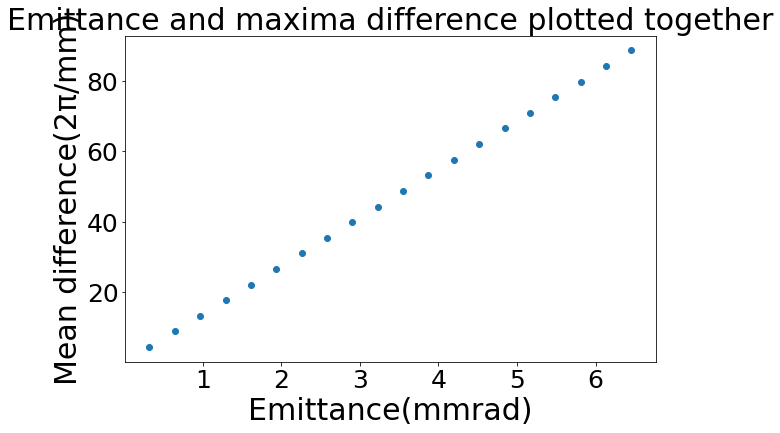

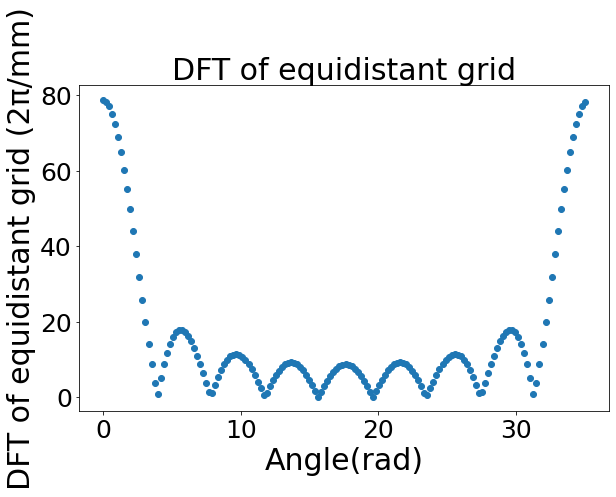

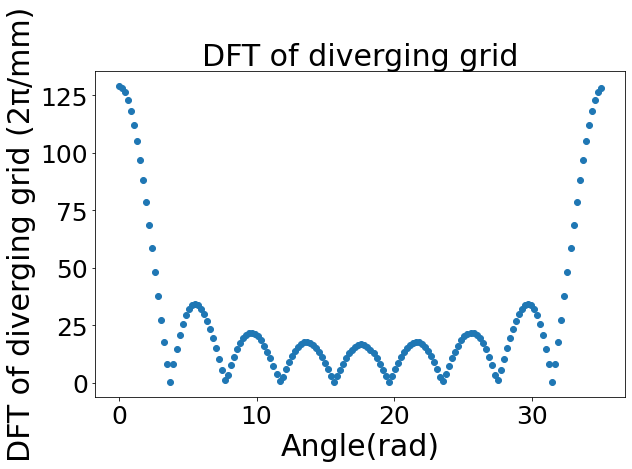

In [1480]:
def Emi_Fourier_corr(n,zeroak):
    emi=np.zeros(n)
    punta=np.zeros(n)
    for i in range(n):
        #Generate meshes
        theta0,r0=RadialMeshGenerator(Aactualmesh,35,0)
        theta05,r05=RadialMeshGenerator(Aactualmesh,35,(i+1)*0.01)
        rex0=np.zeros(len(r0))
        rex05=np.zeros(len(r05))
        #Extract theta=0 meridian from meshes
        for j in range(len(r0)):
            rex0[j]=r0[j][0]
        for j in range(len(r05)):
            rex05[j]=r05[j][0]
        #Calculate r'
        rp=np.zeros(len(rex05))
        for j in range(len(rp)):
            rp[j]=rex05[j]-rex0[j]
        #Calculate emittance
        
        rsmean=np.mean(rex05)#\overline{r}
        rspmean=np.mean(rp)#\overline{r'}
        rs2=np.mean((rex05-rsmean)**2)#\<r^2>
        rsp2=np.mean((rp-rspmean)**2)#\<r'^2>
        rex05rp=np.mean((rex05-rsmean)*(rp-rspmean))#\<rr'>
        emi[i]=np.sqrt(rs2*rsp2-rex05rp**2)
        #Do DFT of data
        rpex=np.zeros(len(rp)+zeroak)
        r0ex=np.zeros(len(rex05)+zeroak)
        r05ex=np.zeros(len(rex0)+zeroak)
        if(np.mod(zeroak,2)!=0):
            zeroak=+1
        a=slice(round(zeroak/2),-round(zeroak/2))
        if(zeroak!=0):
            rpex[a]=rp
            r0ex[a]=rex0
            r05ex[a]=rex05
        else:
            rpex=rp
            r0ex=rex0
            r05ex=rex05
        rpf=DFT(rpex,len(rpex))
        rpff=fft(rpex)
        r0f=DFT(r0ex,len(r0ex))
        r05f=DFT(r05ex,len(r05ex))
        rpfrek=fftfreq(len(rpex),0.5)
    #Calculate mean maxima difference between equidistant and divergent grids
        punta[i]=get_DFT_max(r05f,r0f)
    fig,plot=plt.subplots()
    plot.set_xlabel("Emittance(mmrad)")
    plot.set_ylabel("Mean difference(2π/mm)")
    plot.set_title("Emittance and maxima difference plotted together")
    plot.scatter(emi,punta/len(r05))
    #Linear regresion of plot above
    emi=np.array(emi).reshape(-1,1)
    model = LinearRegression()
    model.fit(emi,punta/len(r05))
    #Slope of linear regresion
    print("erregresio linealaren malda: ",model.coef_[0],)
    print("Erregresio linealaren R^2: ",model.score(emi,punta/len(r05)))
    fig1,plot1=plt.subplots()
    plot1.set_xlabel("Angle(rad)")
    plot1.set_ylabel("DFT of equidistant grid (2π/mm)")
    plot1.set_title("DFT of equidistant grid")
    plot1.scatter(np.linspace(0,35,len(r0f)),np.abs(r0f))
    print(get_frecuency(np.abs(r0f),np.linspace(0,35,len(r0f))))
                  
    fig2,plot2=plt.subplots()
    plot2.set_xlabel("Angle(rad)")
    plot2.set_ylabel("DFT of diverging grid (2π/mm)")
    plot2.set_title("DFT of diverging grid")
    plot2.scatter(np.linspace(0,35,len(r05f)),np.abs(r05f))
    print(get_frecuency(np.abs(r05f),np.linspace(0,35,len(r05f))))

Emi_Fourier_corr(20,150)

# Radial(both from measurement and simulated) emittance, FFT and DFT

Emittance r rms (mmmrad):  16.141615712576606
Emittance r rms (π mmmrad):  5.138035860292747
Mesh position frecuency:  -0.08996837949770685


C:\Users\Usuario\AppData\Local\Temp/ipykernel_1888/1148999161.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  xt[i]=x[i]*np.exp(-2*np.pi*1j*k*i/N)


Measurement position frecuency:  -0.008635021379356839
Measurement divergence frecuency:  -9.008673316051752
Simulated grid position frecuency:  10.84425904507486
Simulated grid divergence frecuency 10.84425904507486


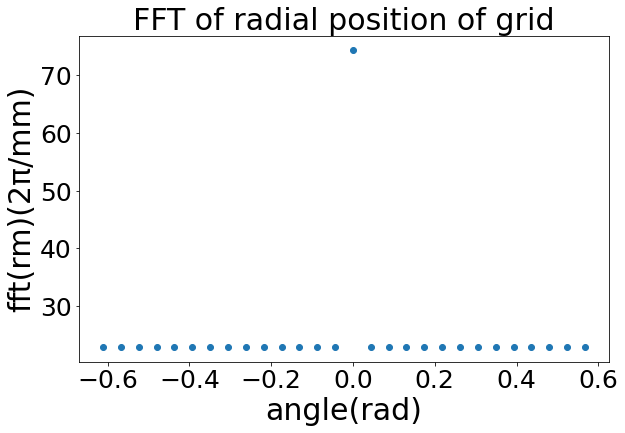

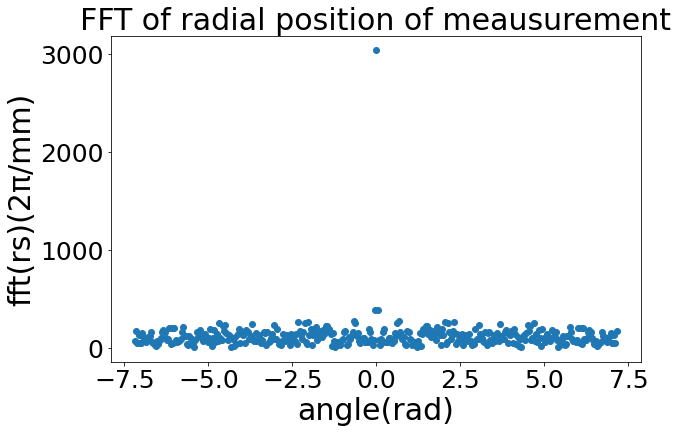

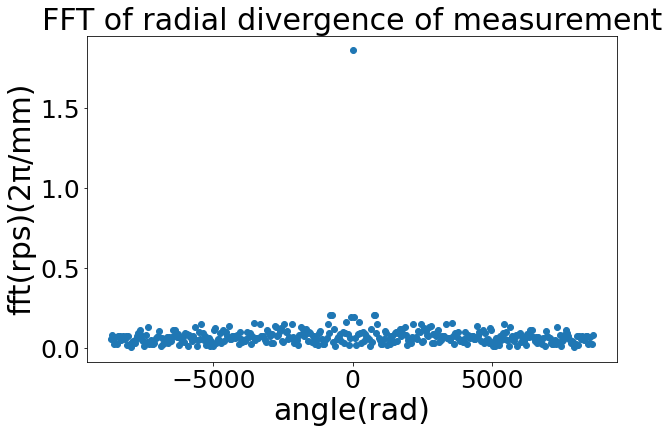

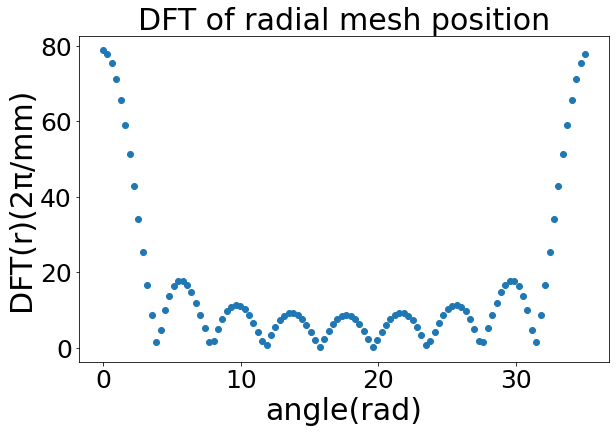

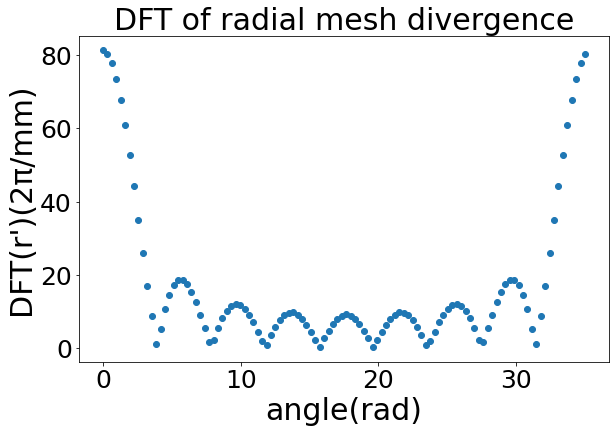

In [1479]:
def get_DFT_max(rfe,rfd):
    maximoak=[]
    # for local minima
    maxima=argrelextrema(rfd,np.greater)[0]
    dif=0
    for maxi in maxima:
        dif+=np.abs(rfd[maxi]-rfe[maxi])
    return dif



    
#Discrete Fourier Transform inplementation
def DFT(x,N):
    xt=np.zeros(N)
    xf=np.zeros(N)
    for k in range(N):
        for i in range(N):
            xt[i]=x[i]*np.exp(-2*np.pi*1j*k*i/N)
        xf[k]=sum(xt)
    return xf
#Detects frecuency of the plot
def get_frecuency(xf,ite):
    erroak=[]
    dif=0
    # for local minima
    minima=argrelextrema(xf,np.less)[0]
    for inde in minima:
            erroak.append(ite[inde])
            for i in range(len(erroak)-1):
                dif+=erroak[i+1]-erroak[i]
    return dif/len(erroak)**2*2*np.pi


print ("Emittance r rms (mmmrad): ", errms)
print ("Emittance r rms (π mmmrad): ", errms/np.pi)
#Radial plot of the Fourier transform
rfg=fft(rm)
rfs=fft(rs)
rpf=fft(rsp)
rfrekg=fftfreq(len(rm),np.abs(np.max(rm)-np.min(rm))/len(rm))
rfreks=fftfreq(len(rs),np.abs(np.max(rs)-np.min(rs))/len(rs))
rspfrek=fftfreq(len(rsp),np.abs(np.max(rsp)-np.min(rsp))/len(rsp))
zeroak=100
r0=np.zeros(len(rex0)+zeroak)
r05=np.zeros(len(rex05)+zeroak)
if(zeroak!=0):
    a=slice(round(zeroak/2),-round(zeroak/2))
    r0[a]=rex0
else:
    r0=rex0
if(zeroak!=0):
    r05[a]=rex05
else:
    r05=rex05
rf0=DFT(r0,len(r0))
rf05=DFT(r05,len(r05))

fig9,plot9=plt.subplots()
plot9.set_xlabel("angle(rad)")
plot9.set_ylabel("fft(rm)(2π/mm)")
plot9.set_title("FFT of radial position of grid")
plot9.scatter(rfrekg,np.abs(rfg))
plt.savefig("Fourierrak/FFT(rm)")
print("Mesh position frecuency: ",get_frecuency(np.abs(rfg),rfrekg))

fig,plot10=plt.subplots()
plot10.set_xlabel("angle(rad)")
plot10.set_ylabel("fft(rs)(2π/mm)")
plot10.set_title("FFT of radial position of meausurement")
plot10.scatter(rfreks,np.abs(rfs))
plt.savefig("Fourierrak/FFT(rs)")
print("Measurement position frecuency: ",get_frecuency(np.abs(rfs),rfreks))

fig11,plot11=plt.subplots()
plot11.set_xlabel("angle(rad)")
plot11.set_ylabel("fft(rps)(2π/mm)")
plot11.set_title("FFT of radial divergence of measurement")
plot11.scatter(rspfrek,np.abs(rpf))
plt.savefig("Fourierrak/FFT(rsp)")
print("Measurement divergence frecuency: ",get_frecuency(np.abs(rpf),rspfrek))

fig12,plot12=plt.subplots()
plot12.set_xlabel("angle(rad)")
plot12.set_ylabel("DFT(r)(2π/mm)")
plot12.set_title("DFT of radial mesh position")
plot12.scatter(np.linspace(0,L,len(rf0)),np.abs(rf0))
print("Simulated grid position frecuency: ",get_frecuency(np.abs(rf0),np.linspace(0,L,len(rf0))))

fig13,plot13=plt.subplots()
plot13.set_xlabel("angle(rad)")
plot13.set_ylabel("DFT(r')(2π/mm)")
plot13.set_title("DFT of radial mesh divergence")
plot13.scatter(np.linspace(0,L,len(rf05)),np.abs(rf05))
print("Simulated grid divergence frecuency",get_frecuency(np.abs(rf05),np.linspace(0,L,len(rf05))))



# Beam intensities plot

In [ ]:
# Get the X and Y arrays
I = df['IntDen'].to_numpy()
Inorm = I/np.max(I) # Nomalized I
rI = df['RawIntDen'].to_numpy()

In [ ]:
fig, ax = plt.subplots()
sca = ax.scatter(xs,ys,c = Inorm, cmap='plasma')
fig.colorbar(sca) 
ax.set_title ("Beam positions and normalized intensities")
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")
plt.savefig ("positions_intensities")

In [ ]:
fig = plt.figure() # figsize=(13, 7)
ax = plt.axes(projection ='3d')
dx=dy=dz=Amesh
ax.bar3d(xs, ys, I,dx,dy,dz, cmap='plasma')

## Another representation to understand the divergence

In [ ]:
# Arrowed plot (default scale)
xsm = np.zeros((len(xs))) # Mesh grid points that mach the beam
ysm = np.zeros((len(xs))) # Mesh grid points that mach the beam
for i in range(len(xs)):
    xsm[i]= xm[int(meshrelation[i][1])]
    ysm[i]= ym[int(meshrelation[i][1])]

fig, ax = plt.subplots()
ax.scatter(xs,ys,color="#CC0000", label="beam")
ax.scatter(xsm,ysm,color="#6AA84F", label="matching")

u = xs-xsm
v = ys-ysm
color = np.sqrt((xs-xsm)**2+(ys-ysm)**2)

fig, ax = plt.subplots()
sca = ax.quiver(xsm,ysm,u,v, color, label="Scaled")
ax.legend()
fig.colorbar(sca)
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")
plt.savefig ("beam_positions_arrows_scaled")
plt.show()

# Arrowed normalized plot
usm = np.zeros((len(xs)))
vsm = np.zeros((len(xs)))
# In the center point we diveide by 0
for i in range(len(xs)):
    if np.sqrt((xs[i]-xsm[i])**2+(ys[i]-ysm[i])**2) == 0:
        print ("sqrt = 0 @ index i = ", i)
u = (xs-xsm)/np.sqrt((xs-xsm)**2+(ys-ysm)**2)
v = (ys-ysm)/np.sqrt((xs-xsm)**2+(ys-ysm)**2)
color = np.sqrt((xs-xsm)**2+(ys-ysm)**2)

fig, ax = plt.subplots()
#ax.scatter(xs,ys,color="#CC0000", label="beam")
#ax.scatter(xsm,ysm,color="#6AA84F", label="matching")
sca = ax.quiver(xsm,ysm,u,v, color="#1f77b4", label = "Normalized")
fig.colorbar(sca)
ax.legend()
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")
plt.savefig ("beam_positions_arrows_normalized")
plt.show()

In [ ]:
# We need to have np.arrays to be able to scale the quiver plot

npxsm = np.zeros((len(xs))) # Mesh grid points that mach the beam
npysm = np.zeros((len(xs))) # Mesh grid points that mach the beam
npxs = np.zeros((len(xs))) # Mesh grid points that mach the beam
npys = np.zeros((len(xs))) # Mesh grid points that mach the beam
for i in range(len(xs)):
    npxsm[i]= np.array((xm[int(meshrelation[i][1])]))
    npysm[i]= np.array((ym[int(meshrelation[i][1])]))
    npxs [i] = np.array((xs[i]))
    npys [i] = np.array((ys[i]))

fig, ax = plt.subplots()
#ax.scatter(xm, ym, marker = 'o',label="pepperpot")
ax.scatter(xs,ys,color="#CC0000", label="beam")
ax.scatter(xsm,ysm,color="#6AA84F", label="matching")

u = npxs-npxsm
v = npys-npysm
color = np.sqrt((xs-xsm)**2+(ys-ysm)**2)
fig, ax = plt.subplots()
#ax.scatter(xs,ys,color="#CC0000", label="beam")
#ax.scatter(xsm,ysm,color="#6AA84F", label="matching")
ax.quiver(npxsm,npysm,u,v, color, units='xy' ,scale=1, label="Not scaled")
ax.legend()
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")
plt.savefig ("beam_positions_arrows_no_scale")
plt.show()